# **Разработка модели предсказания рыночной цены аренды квартиры по заданным параметрам**

In [1]:
!gdown 1YqsUX79zQJIohxOg_Qo-cYu3HEbVyseV

Downloading...
From: https://drive.google.com/uc?id=1YqsUX79zQJIohxOg_Qo-cYu3HEbVyseV
To: /content/Выборка данных по аренде жилья.csv
100% 370k/370k [00:00<00:00, 76.8MB/s]


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

In [127]:
df = pd.read_csv('Выборка данных по аренде жилья.csv')
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,id,create_date,rent_price,deposit,floor,area_total,rooms,region,repair_type,agent_fee
0,1,2021-12-06 09:54:22.001 +0300,88400,NaN,2,63.2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2021-12-06 09:52:18.815 +0300,88100,NaN,6,53.6,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2021-12-06 09:48:26.329 +0300,36000,NaN,9,39,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2021-12-06 09:46:42.017 +0300,35000,NaN,5,40,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2021-12-06 09:45:50.589 +0300,30000,NaN,8,28,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Предобработка данных**

**1. Корректировка названий и удаление лишних столбцов**

In [129]:
# Удаляем ненужные столбцы и сразу присваиваем новые имена оставшимся
df = df.drop(['deposit', 'floor', 'area_total', 'rooms', 'region',
              'repair_type', 'agent_fee'], axis=1)
df.columns = ['id', 'create_date', 'rent_price', 'deposit', 'floor',
              'area_total', 'rooms', 'region', 'repair_type', 'agent_fee']

In [130]:
# Все названия столбцов соответсвуют их содержанию
df.head()


,id,create_date,rent_price,deposit,floor,area_total,rooms,region,repair_type,agent_fee
0,1,2021-12-06 09:54:22.001 +0300,88400,NaN,2,63.2,2,1,NaN,NaN
1,2,2021-12-06 09:52:18.815 +0300,88100,NaN,6,53.6,2,1,NaN,NaN
2,3,2021-12-06 09:48:26.329 +0300,36000,NaN,9,39,1,1,NaN,NaN
3,4,2021-12-06 09:46:42.017 +0300,35000,NaN,5,40,1,1,NaN,NaN
4,5,2021-12-06 09:45:50.589 +0300,30000,NaN,8,28,0,2,NaN,NaN


**2. Основная информация о данных в таблице**

In [131]:
# Информация о данных в таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           5000 non-null   int64  
 1   create_date  5000 non-null   object 
 2   rent_price   5000 non-null   int64  
 3   deposit      4912 non-null   float64
 4   floor        5000 non-null   int64  
 5   area_total   5000 non-null   object 
 6   rooms        5000 non-null   int64  
 7   region       5000 non-null   int64  
 8   repair_type  4912 non-null   object 
 9   agent_fee    4912 non-null   float64
dtypes: float64(2), int64(5), object(3)
memory usage: 390.8+ KB



**Выводы**

- Столбец '**area_total**' (площадь помещения) имеет тип данных object,при этом данные в нем это дробные числа.

- Столбец '**create_date**' (Дата объявления) имеет тип данных object,при этом данные в нем это дата и время.

- Столбцы '**deposit**','**repair_type**' и '**agent_fee**' содержат пропуски

**3. Поиск и замена пропущенных значений**

In [8]:
df.isnull().sum() # Количество пропущенных значений в столбцах

,0
id,0
create_date,0
rent_price,0
deposit,88
floor,0
area_total,0
rooms,0
region,0
repair_type,88
agent_fee,88


In [9]:
# Смотрим, какие уникальные значения есть в категориальном столбце 'repair_type' ,чтобы решить что делать с пропусками
df['repair_type'].unique()

array([nan, 'design', 'cosmetic', 'euro', 'unknown', 'no'], dtype=object)

In [10]:
# Смотрим, как выглядят значения в остальных строках где в'deposit' отсутствет значение
df[df['deposit'].isna()].head(5)

,id,create_date,rent_price,deposit,floor,area_total,rooms,region,repair_type,agent_fee
0,1,2021-12-06 09:54:22.001 +0300,88400,NaN,2,63.2,2,1,NaN,NaN
1,2,2021-12-06 09:52:18.815 +0300,88100,NaN,6,53.6,2,1,NaN,NaN
2,3,2021-12-06 09:48:26.329 +0300,36000,NaN,9,39,1,1,NaN,NaN
3,4,2021-12-06 09:46:42.017 +0300,35000,NaN,5,40,1,1,NaN,NaN
4,5,2021-12-06 09:45:50.589 +0300,30000,NaN,8,28,0,2,NaN,NaN


In [11]:
# Смотрим, как выглядят значения в строках столбца где в 'agent_fee' отсутствет значение
df[df['agent_fee'].isna()].head(5)

,id,create_date,rent_price,deposit,floor,area_total,rooms,region,repair_type,agent_fee
0,1,2021-12-06 09:54:22.001 +0300,88400,NaN,2,63.2,2,1,NaN,NaN
1,2,2021-12-06 09:52:18.815 +0300,88100,NaN,6,53.6,2,1,NaN,NaN
2,3,2021-12-06 09:48:26.329 +0300,36000,NaN,9,39,1,1,NaN,NaN
3,4,2021-12-06 09:46:42.017 +0300,35000,NaN,5,40,1,1,NaN,NaN
4,5,2021-12-06 09:45:50.589 +0300,30000,NaN,8,28,0,2,NaN,NaN


In [12]:
# Заменяем отсутвующие значения в 'deposit на занчение из столбца price rent этой квартиры,тк в большинстве данных,депозит составляет сумму 1 месяца аренды
df['deposit'] = df['deposit'].fillna(df['rent_price'])

In [13]:
# Заменяем пропущеннные значения в 'agent_fee' на 0
df['agent_fee'] = df['agent_fee'].fillna(0)

In [14]:
# Заменяем пропущеннные значения в 'repair_type' на значение 'unknown'
df['repair_type'] = df['repair_type'].fillna('unknown')

**4. Приведение столбцов к нужному типу данных**

In [15]:
# Форматируем столбец 'area_total': убраем лишние символы и приводим данные к типу float
df['area_total'] = df['area_total'].replace(r'[^0-9.]', '', regex=True)
df['area_total']=df['area_total'].astype(float)

In [16]:
# Приводим данные столбца'create_date' к типу данных datetime и создаем новый признак'date_only'-день подачи объявленя
df['create_date'] =pd.to_datetime(df['create_date'])
df['date_only'] = df['create_date'].dt.date

**5. Поиск и удаление дубликатов**

In [17]:
# Найдено 128 дубликатов совпадающих по 9 признакам
duplicates=df.duplicated(subset=['rent_price', 'deposit', 'floor', 'area_total', 'rooms', 'region','repair_type','agent_fee','date_only'], keep=False)
print(f"Всего дубликатов: {duplicates.sum()}")

Всего дубликатов: 128


In [18]:
# Выводим строки с дупликатами,чтобы убедиться что их можно удалить
duplicated_rows = df[duplicates].sort_values(by=['rent_price', 'region'])
display(duplicated_rows.head(6))

,id,create_date,rent_price,deposit,floor,area_total,rooms,region,repair_type,agent_fee,date_only
200,201,2021-12-05 22:41:39.355000+03:00,20000,20000.0,16,38.7,1,2,cosmetic,0.0,2021-12-05
524,525,2021-12-05 17:45:21.924000+03:00,20000,20000.0,16,38.7,1,2,cosmetic,0.0,2021-12-05
376,377,2021-12-05 20:10:20.327000+03:00,25000,25000.0,3,54.0,2,2,cosmetic,0.0,2021-12-05
589,590,2021-12-05 16:49:24.226000+03:00,25000,25000.0,3,54.0,2,2,cosmetic,0.0,2021-12-05
3429,3430,2021-12-02 22:58:47.020000+03:00,25000,25000.0,7,35.0,1,2,euro,0.0,2021-12-02
3434,3435,2021-12-02 22:55:55.791000+03:00,25000,25000.0,7,35.0,1,2,euro,0.0,2021-12-02


In [19]:
# Удаляем дубликаты
df.drop_duplicates(
    subset=['rent_price', 'deposit', 'floor', 'area_total', 'rooms', 'region', 'repair_type', 'agent_fee', 'date_only'],
    keep='first',inplace=True)

**6. Описательная статистика**

In [20]:
df.describe()

,id,rent_price,deposit,floor,area_total,rooms,region,agent_fee
count,4935.000000,4935.000000,4.935000e+03,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000
mean,2497.641337,56544.788247,7.191925e+04,7.397974,59.247031,1.611550,1.251874,41.430598
std,1442.613127,41269.791279,1.423422e+06,5.599641,640.314190,0.882926,0.434133,33.146534
min,1.000000,6300.000000,0.000000e+00,1.000000,12.000000,-1.000000,1.000000,0.000000
25%,1249.500000,35000.000000,3.000000e+04,3.000000,36.550000,1.000000,1.000000,0.000000
50%,2495.000000,45000.000000,4.300000e+04,6.000000,44.000000,2.000000,1.000000,50.000000
75%,3745.500000,60000.000000,6.000000e+04,10.000000,58.000000,2.000000,2.000000,50.000000
max,5000.000000,300000.000000,1.000000e+08,55.000000,45000.000000,6.000000,2.000000,100.000000


  **Выводы**

- Столбец '**rooms**' (количество комнат) имеет отрицательное значение,возможно это ошибочное значение.

- Столбец '**deposit**' (Депозит) имеет очень большой диапазон значенийи экстримальную максимальную величину в размере

 **100 000 000 р.**

- Максиальное значение столбца '**area_total**'  имеет очень высокий показатель

 **45000** кв.м.



# **Анализ и преобразование столбцов**

**1. Столбец 'area_total'- Площадь помещения**

- Максиальное значение столбца имеет значение
45000 кв.м.

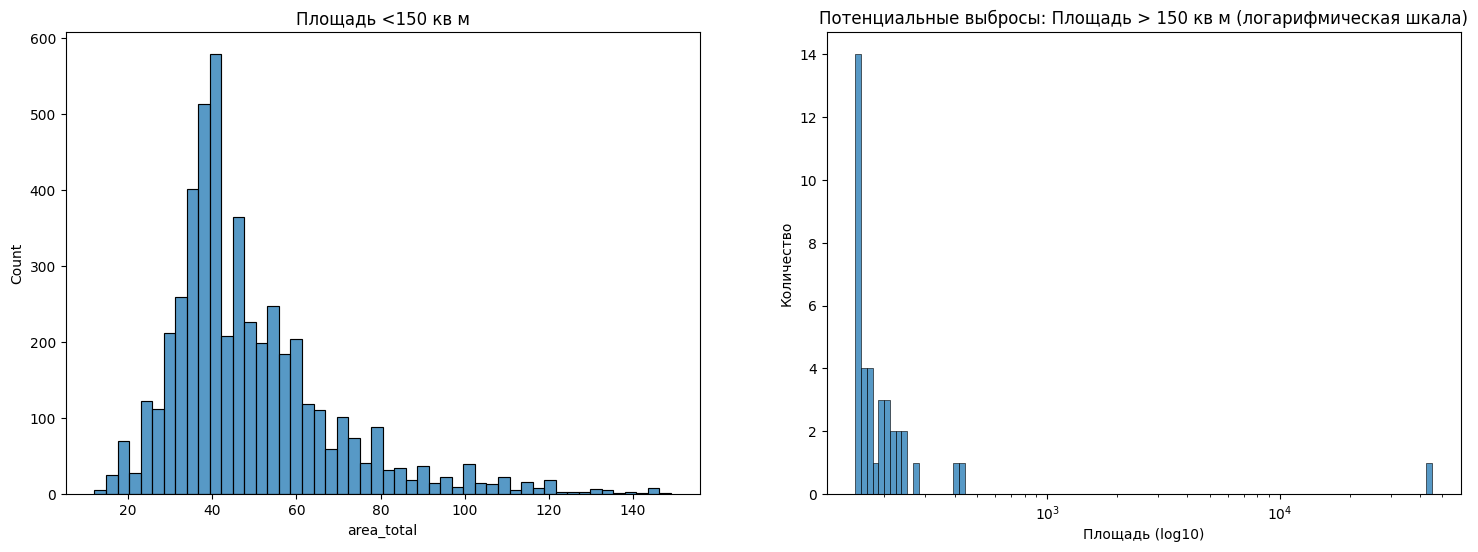

In [21]:
# Построим графики распределения площади квартир
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
# Основное распределение
sns.histplot(df[df['area_total'] <150], x='area_total', bins=50, ax=ax1)
ax1.set_title("Площадь <150 кв м")
# Потенциальные выбросы(используем логарифмеческую шкалу  для одновременного отображения малых и экстремально больших значений)
sns.histplot(df[df['area_total'] >= 150], x='area_total', bins=100, log_scale=True)
plt.title("Потенциальные выбросы: Площадь > 150 кв м (логарифмическая шкала)")
plt.xlabel("Площадь (log10)")
plt.ylabel("Количество")
plt.show()

**Вывод по графику**

- Наибольшее количество квартир имееет площадь от 30 до 50 кв.м.

- Имеются единичные выбросы.

In [22]:
 # Ищем аномалии в столбце 'area_total'
area_strange = df[df['area_total'] > 150].sort_values('area_total', ascending=False)
display(area_strange.head())

,id,create_date,rent_price,deposit,floor,area_total,rooms,region,repair_type,agent_fee,date_only
2946,2947,2021-12-03 13:55:15.036000+03:00,45000,45000.0,8,45000.0,1,1,euro,30.0,2021-12-03
828,829,2021-12-05 13:15:29.957000+03:00,30000,30000.0,2,428.0,1,1,unknown,50.0,2021-12-05
1473,1474,2021-12-04 18:11:34.326000+03:00,24000,24000.0,7,407.0,1,2,cosmetic,50.0,2021-12-04
2858,2859,2021-12-03 14:22:10.724000+03:00,290000,290000.0,11,280.0,5,1,design,0.0,2021-12-03
1540,1541,2021-12-04 17:02:54.930000+03:00,250000,250000.0,3,245.0,4,2,unknown,50.0,2021-12-04


In [23]:
# Отредактируем значения столбца 'area_total', в строках с опечатками
df.loc[828, 'area_total'] = 42.8
df.loc[1473, 'area_total'] = 40.7
df.loc[2946, 'area_total'] = 45

In [24]:
# Проверка исправления
indices_to_check = [828, 1473, 2946]
display(df.loc[indices_to_check, ['id','area_total', 'rent_price', 'rooms']])

,id,area_total,rent_price,rooms
828,829,42.8,30000,1
1473,1474,40.7,24000,1
2946,2947,45.0,45000,1


**Выводы по столбцу**

 Есть 3 записи площадью помещения > 400 кв.м.

 Основываясь на значениях в остальных столбцах и средними ценами за кв.м.,

 можно сделать вывод что при вводе данных произошла опечатка.


In [25]:
# Проверка максимального значения площади
df['area_total'].max()

280.0

**2. Столбец 'deposit'- депозит**

- Имеет очень большой диапазон значениий;

- Есть объявление с депозитом = 0;

- Максимальная сумма депозита составляет 100 000 000 р.

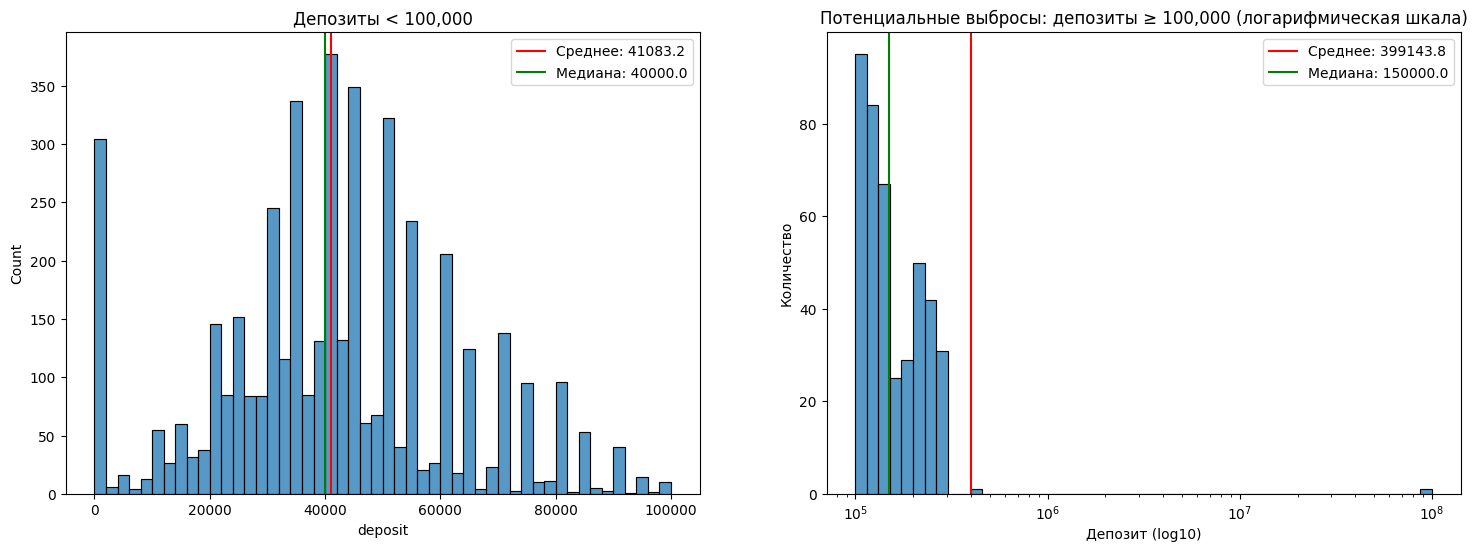

In [26]:
# Построим графики распределения депозита
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Фильтруем данные
df_low = df[df['deposit'] < 100000]
df_high = df[df['deposit'] >= 100000]

# Основное распределение (депозиты < 100,000)
sns.histplot(df_low, x='deposit', bins=50, ax=ax1)
ax1.set_title("Депозиты < 100,000")
# Линии для первого графика (по всем данным)
ax1.axvline(x=df_low['deposit'].mean(), color='red', label=f'Среднее: {df_low["deposit"].mean():.1f}')
ax1.axvline(x=df_low['deposit'].median(), color='green', label=f'Медиана: {df_low["deposit"].median():.1f}')
ax1.legend()

# Потенциальные выбросы (депозиты ≥ 100,000)
sns.histplot(df_high, x='deposit', bins=50, log_scale=True, ax=ax2)
# Линии для второго графика (только по данным ≥ 100,000)
ax2.axvline(x=df_high['deposit'].mean(), color='red', label=f'Среднее: {df_high["deposit"].mean():.1f}')
ax2.axvline(x=df_high['deposit'].median(), color='green', label=f'Медиана: {df_high["deposit"].median():.1f}')
ax2.legend()

ax2.set_title("Потенциальные выбросы: депозиты ≥ 100,000 (логарифмическая шкала)")
ax2.set_xlabel("Депозит (log10)")
ax2.set_ylabel("Количество")

plt.show()

  **Выводы по графику**

- *Квартиры без депозита:*

 278 квартир сдается без депозита.

- *Квартиры с депозитом < 100 000:*

 Средняя сумма депозита составляет 41 083 р.

 Медианная сумма депозита составляет 40 000 р.

 Разница между медианой и средней ценой составляет 1083 р.

 В этом диапазоне данные равномерны.

- *Квартиры с депозитом > 100 000:*

 Средняя сумма депозита составляет  399 143 р.

 Медианная сумма депозита составляет 150 000 р.

 Разница между медианой и средней ценой составляет 249 143 р.

 В этом диапазон с большой вероятностью присутсвуют выбросы.
                                                                   

In [27]:
# Смотрим на объявления с депозитом=0
dep_0=df[df['deposit']==0].sort_values('rent_price', ascending=False)
display(dep_0.head())
len(dep_0)

,id,create_date,rent_price,deposit,floor,area_total,rooms,region,repair_type,agent_fee,date_only
3998,3999,2021-12-02 16:41:04.691000+03:00,240000,0.0,3,120.0,4,1,design,0.0,2021-12-02
780,781,2021-12-05 13:48:43.306000+03:00,210000,0.0,31,50.0,1,1,design,0.0,2021-12-05
1943,1944,2021-12-04 06:59:06.033000+03:00,200000,0.0,3,70.6,3,1,euro,50.0,2021-12-04
3281,3282,2021-12-03 03:34:23.325000+03:00,194900,0.0,8,95.5,3,1,euro,50.0,2021-12-03
1949,1950,2021-12-04 05:23:15.309000+03:00,184700,0.0,15,170.0,4,1,euro,50.0,2021-12-04


278

In [28]:
# Создадим отфильтрованный датасет,где депозит больше цены аренды и сумма депозита >100 000
deposit_diff = df[(df['deposit'] > df['rent_price']) & (df['deposit'] > 100000)].sort_values('deposit', ascending=False)
display(deposit_diff.head())

,id,create_date,rent_price,deposit,floor,area_total,rooms,region,repair_type,agent_fee,date_only
1396,1397,2021-12-04 18:59:59.215000+03:00,75000,100000000.0,10,50.0,2,1,euro,100.0,2021-12-04
1602,1603,2021-12-04 16:05:06.634000+03:00,300000,450000.0,55,202.0,3,1,cosmetic,0.0,2021-12-04
426,427,2021-12-05 19:08:26.701000+03:00,160000,180000.0,12,52.0,2,1,design,30.0,2021-12-05
1491,1492,2021-12-04 17:56:12.308000+03:00,150000,160000.0,9,57.0,0,1,design,0.0,2021-12-04
2317,2318,2021-12-03 20:24:21.532000+03:00,140000,150000.0,11,64.0,3,1,design,50.0,2021-12-03


In [29]:
# Создадим переменную 'count_month' с данными, за сколько месяцев аренды берется депозит(часто депозиты составляют 1-3 месяца суммы аренды)
deposit_diff['count_month'] = deposit_diff['deposit'] / deposit_diff['rent_price']

In [30]:
# Выводим строки, где депозит первышает цену  за 3 месяца аренды квартиры
display(
    deposit_diff[deposit_diff['count_month']>=3]
    .sort_values('count_month', ascending=False))

,id,create_date,rent_price,deposit,floor,area_total,rooms,region,repair_type,agent_fee,date_only,count_month
1396,1397,2021-12-04 18:59:59.215000+03:00,75000,100000000.0,10,50.0,2,1,euro,100.0,2021-12-04,1333.333333
1753,1754,2021-12-04 13:53:51.929000+03:00,45000,135000.0,2,37.2,1,1,design,0.0,2021-12-04,3.000000


In [31]:
# На основании проведенного анализа можно сделать вывод что это была ошибка ввода,заменим значение 100 000 000 на 100 000
df.loc[df['id'] == 1397, 'deposit'] = 100000

In [32]:
# Проверка max значения депозита после обработки
df['deposit'].max()

450000.0

**3. Столбец 'rooms'-количество комнат в квартире**

 - Отрицательное значение в столбце;

 - 328 квартир имеют 0 комнат.



*Квартиры с количеством комнат = -1*

In [33]:
# Проверяем строки с отрицательным значением
df[df['rooms']==-1]

,id,create_date,rent_price,deposit,floor,area_total,rooms,region,repair_type,agent_fee,date_only
429,430,2021-12-05 19:02:28.648000+03:00,100000,50000.0,6,44.8,-1,1,design,0.0,2021-12-05


In [34]:
# При детальном расмотрении данных,сделали вывод что отрицательное значение в столбце 'rooms' поставлено по ошибке,заменим его на 1
df['rooms'] = df['rooms'].replace(-1, 1)

*Квартиры с количеством комнат = 0*

In [35]:
# Смотрим сколько квартир имеют 0 комнат
print(len(df[df['rooms'] == 0]))

328


In [36]:
# Отфильтруем квартиры-студии по площади > 50 кв.м.
zero_rooms = df[(df['rooms'] == 0) & (df['area_total'] >= 50)]
print(zero_rooms[['id','rooms', 'area_total', 'rent_price','deposit','region']])
print(len(zero_rooms),'квартир имеют 0 комнат и площадь > 50 кв.м.')

        id  rooms  area_total  rent_price   deposit  region
89      90      0        62.0      150000  150000.0       1
212    213      0        57.0      150000  150000.0       1
803    804      0        60.0       16900       0.0       1
1428  1429      0        52.0       63000   31500.0       1
1491  1492      0        57.0      150000  160000.0       1
2014  2015      0        60.0       13990       0.0       1
2015  2016      0        60.0       13990       0.0       1
2149  2150      0        62.0       32000   15000.0       1
2668  2669      0        57.0      150000  150000.0       1
3529  3530      0        54.0       56000   50000.0       2
3531  3532      0        54.0       56000   50000.0       2
4566  4567      0        57.0      150000  150000.0       1
12 квартир имеют 0 комнат и площадь > 50 кв.м.


In [37]:
# Удаляем квартиры с очевидными ошибками в строках~
df = df.query("id not in [804, 2015, 2016]")

**Выводы**

- *Квартиры с количеством комнат =-1*

 При детальном рассмотрении видно,

 что отрицательное значение поставлено по ошибке,заменим его на 1

- *Квартиры с количеством комнат = 0*

 Квартиры-студии с 0 комнат обычно имеют площадь < 50 кв.м.

 Есть  **12** квартир с  площадью в диапазоне **50-60 кв.м**.

 **3** из них имеют оченью низкую цену,что отличается

 от средней рыночной цены за такую площадь и не имеют депозита.

 В совокупности всех факторов,лучше удалить эти 3 строки.

 Остальные данные выглядят логично,

 хоть и имеют нетипичное соотношение количество комнат/площадь квартиры.

**4. Столбец 'repair_type'- Тип ремонта**

- Есть 5 категориальных уникальных значений характеризующих вид ремонта квартиры:

 **'design', 'cosmetic', 'euro', 'unknown','no'.**

- Нужно извлечь все значения в отдельные столбцы,чтобы определить корреляцию   каждого значения к целевой переменой.


In [38]:
# Сохраняем исходный столбец
df['repair_type_original'] = df['repair_type'].copy()
# Разделим категориальные значения по столбцам
df = pd.get_dummies(df, columns=['repair_type'], prefix='renovation', dtype=int)
df.head()

,id,create_date,rent_price,deposit,floor,area_total,rooms,region,agent_fee,date_only,repair_type_original,renovation_cosmetic,renovation_design,renovation_euro,renovation_no,renovation_unknown
0,1,2021-12-06 09:54:22.001000+03:00,88400,88400.0,2,63.2,2,1,0.0,2021-12-06,unknown,0,0,0,0,1
1,2,2021-12-06 09:52:18.815000+03:00,88100,88100.0,6,53.6,2,1,0.0,2021-12-06,unknown,0,0,0,0,1
2,3,2021-12-06 09:48:26.329000+03:00,36000,36000.0,9,39.0,1,1,0.0,2021-12-06,unknown,0,0,0,0,1
3,4,2021-12-06 09:46:42.017000+03:00,35000,35000.0,5,40.0,1,1,0.0,2021-12-06,unknown,0,0,0,0,1
4,5,2021-12-06 09:45:50.589000+03:00,30000,30000.0,8,28.0,0,2,0.0,2021-12-06,unknown,0,0,0,0,1


**5. Столбец floor - этаж**
- Посмотреть распределение цен на аренду квартир  по этажам

In [39]:
# Группируем по этажам и вычисляем медианную цену за аренду
price_by_floor = df.groupby('floor')['rent_price'].median().reset_index()
price_by_floor_sorted = price_by_floor.sort_values('floor', ascending=False)
display(price_by_floor_sorted.head(10))

,floor,rent_price
40,55,300000.0
39,52,30000.0
38,50,300000.0
37,49,300000.0
36,47,26990.0
35,46,26990.0
34,40,130000.0
33,39,120000.0
32,38,109000.0
31,32,100000.0


In [40]:
# Т.к. мы увидели явные выбросы в ценах для квартир высоких этажах,надо посмотреть соотношение цена/этаж(для этажей > 40)
floor_hight=df[df['floor']>=40].sort_values('rent_price', ascending=True)
display(floor_hight.head())

,id,create_date,rent_price,deposit,floor,area_total,rooms,region,agent_fee,date_only,repair_type_original,renovation_cosmetic,renovation_design,renovation_euro,renovation_no,renovation_unknown
1684,1685,2021-12-04 14:59:49.658000+03:00,26990,0.0,46,95.0,2,1,0.0,2021-12-04,euro,0,0,1,0,0
1863,1864,2021-12-04 11:56:37.708000+03:00,26990,0.0,47,95.0,2,1,0.0,2021-12-04,euro,0,0,1,0,0
2807,2808,2021-12-03 14:53:31.188000+03:00,30000,30000.0,52,133.0,3,1,0.0,2021-12-03,unknown,0,0,0,0,1
3870,3871,2021-12-02 17:47:02.521000+03:00,100000,100000.0,40,70.0,2,1,30.0,2021-12-02,euro,0,0,1,0,0
3779,3780,2021-12-02 18:25:50.351000+03:00,130000,130000.0,40,67.0,2,1,0.0,2021-12-02,design,0,1,0,0,0


In [41]:
# Отредактируем явные опечатки в строках
df.loc[1684, 'rent_price'] = 269900
df.loc[1863, 'rent_price'] = 269900
df.loc[2807, 'rent_price'] = 300000

In [42]:
# Проверка исправления
indices_to_check = [1684, 1863, 2807]
display(df.loc[indices_to_check, ['id','area_total', 'rent_price', 'rooms']])

,id,area_total,rent_price,rooms
1684,1685,95.0,269900,2
1863,1864,95.0,269900,2
2807,2808,133.0,300000,3


In [43]:
# Сгруппируем обновленные данные по этажам и посмотреим распределение цены
price_by_floor_new = df.groupby('floor')['rent_price'].median().reset_index()

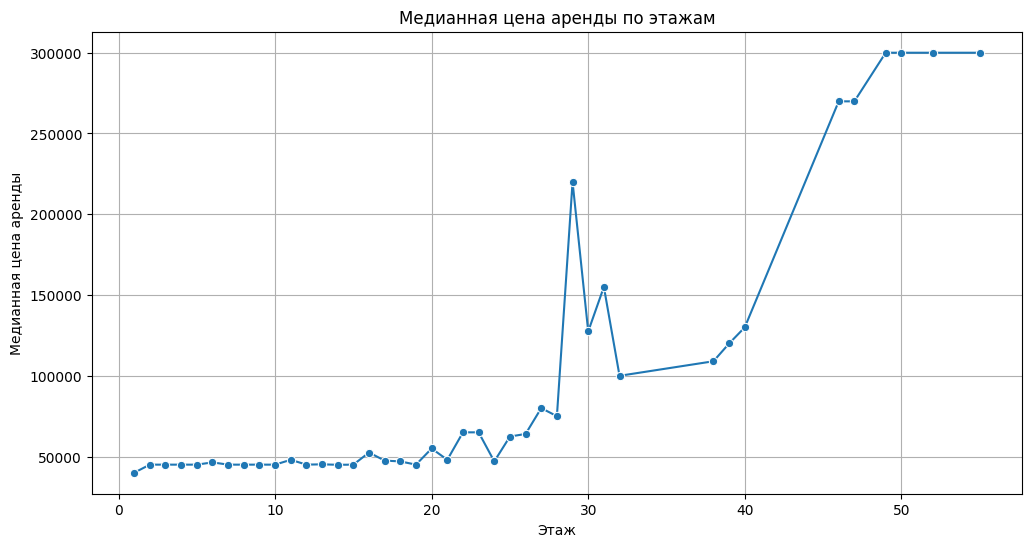

In [44]:
# Построим график распределение цены по этажам
plt.figure(figsize=(12, 6))
sns.lineplot(x='floor', y='rent_price', data=price_by_floor_new, marker='o')
plt.title('Медианная цена аренды по этажам')
plt.xlabel('Этаж')
plt.ylabel('Медианная цена аренды')
plt.grid()
plt.show()

**Вывод по графику**

По графику четко прослеживается тенденция - чем выше этаж,тем дороже арендная плата за квартиру

# **Анализ целевой переменной 'rent_price'**

**1. Статистические данные**

In [45]:
#Для анализа цены посмотрим на интерквартальный размах, верхюю и нижнюю границу цен
Q1 = df['rent_price'].quantile(0.25)
Q3 = df['rent_price'].quantile(0.75)
IQR = Q3 - Q1
print('Интерквартальный размах составляет:',IQR)

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
lower_bound = max(lower_bound, df['rent_price'].min())
print(f"Границы: [{lower_bound:.0f}, {upper_bound:.0f}] руб.")
print(f"Минимум после обработки: {df['rent_price'].min():.0f} руб.")
print(f"Максимум после обработки: {df['rent_price'].max():.0f} руб.")

Интерквартальный размах составляет: 25000.0
Границы: [6300, 97500] руб.
Минимум после обработки: 6300 руб.
Максимум после обработки: 300000 руб.


In [46]:
# Средняя и медианная цена
round(df['rent_price'].mean()),round(df['rent_price'].median())

(56723, 45000)

**2. Сегментация рынка по арендной цене**

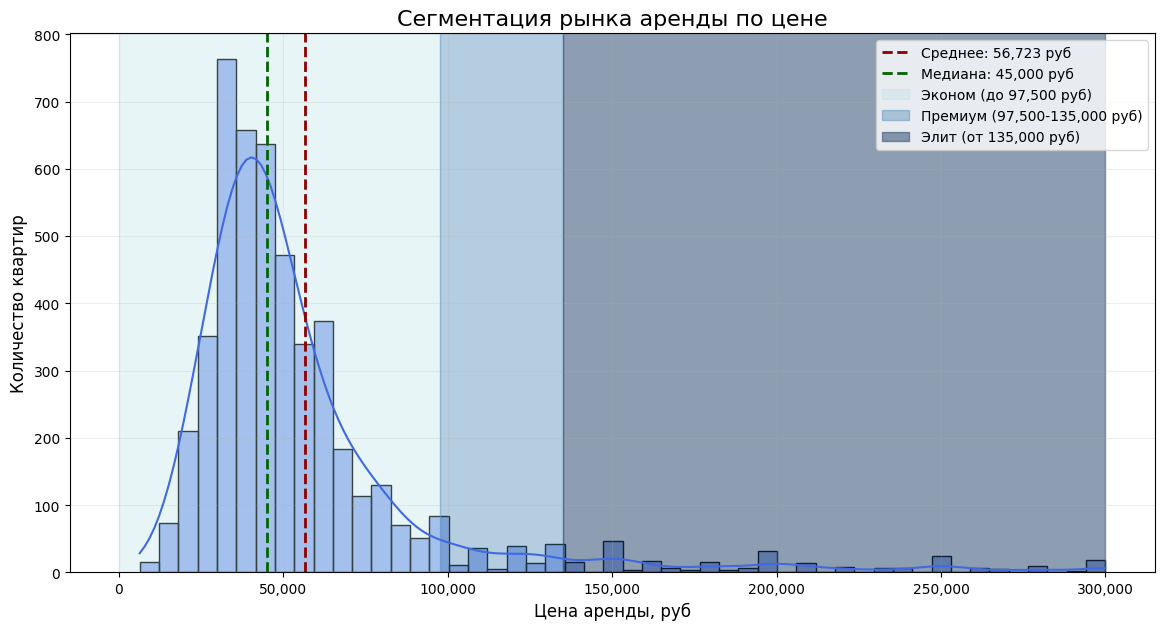


Статистические показатели:
1. Средняя цена (56,723 руб) > медианной (45,000 руб) на 26%
2. Коэффициент асимметрии: 3.04 (сильная правосторонняя асимметрия)

Автоматически определенные границы сегментов:
- Эконом-сегмент: до 97,500 руб
- Премиум-сегмент: 97,500 - 135,000 руб
- Элитный сегмент: свыше 135,000 руб

Распределение по сегментам:
- Эконом: 4458 квартир (90.4%)
- Премиум: 219 квартир (4.4%)
- Элит: 255 квартир (5.2%)


In [47]:
# Построим график распределения цен с разделением на сегменты рынка
plt.figure(figsize=(14, 7))

# Гистограмма
ax = sns.histplot(df, x='rent_price', kde=True, bins=50, log_scale=False, color='#4169E1')

# Показатели
mean_price = df['rent_price'].mean()
median_price = df['rent_price'].median()
skewness = skew(df['rent_price'])

# Линии среднего и медианы
mean_line = ax.axvline(mean_price, color='darkred', linestyle='--',
                      linewidth=2, label=f'Среднее: {mean_price:,.0f} руб')
median_line = ax.axvline(median_price, color='darkgreen', linestyle='--',
                        linewidth=2, label=f'Медиана: {median_price:,.0f} руб')

# Определение границ сегментов
q25, q75 = df['rent_price'].quantile([0.25, 0.75])
iqr = q75 - q25
econom_threshold = q75 + 1.5*iqr
elite_threshold = q75 + 3*iqr

# Палитра оттенков синего
palette = {
    'Эконом': '#B0E0E6',  # PowderBlue
    'Премиум': '#4682B4',  # SteelBlue
    'Элит': '#1E3F66'      # DarkSlateBlue
}

# Визуализация сегментов
ax.axvspan(0, econom_threshold, alpha=0.3, color=palette['Эконом'], label=f'Эконом (до {econom_threshold:,.0f} руб)')
ax.axvspan(econom_threshold, elite_threshold, alpha=0.4, color=palette['Премиум'],
           label=f'Премиум ({econom_threshold:,.0f}-{elite_threshold:,.0f} руб)')
ax.axvspan(elite_threshold, df['rent_price'].max(), alpha=0.5, color=palette['Элит'],
           label=f'Элит (от {elite_threshold:,.0f} руб)')

# Настройки графика
plt.title('Сегментация рынка аренды по цене', fontsize=16)
plt.xlabel('Цена аренды, руб', fontsize=12)
plt.ylabel('Количество квартир', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.2)

# Форматирование оси X
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.show()

# Анализ
print("\nСтатистические показатели:")
print(f"1. Средняя цена ({mean_price:,.0f} руб) > медианной ({median_price:,.0f} руб) на {((mean_price-median_price)/median_price)*100:.0f}%")
print(f"2. Коэффициент асимметрии: {skewness:.2f} (сильная правосторонняя асимметрия)")
print(f"\nАвтоматически определенные границы сегментов:")
print(f"- Эконом-сегмент: до {econom_threshold:,.0f} руб")
print(f"- Премиум-сегмент: {econom_threshold:,.0f} - {elite_threshold:,.0f} руб")
print(f"- Элитный сегмент: свыше {elite_threshold:,.0f} руб")

# Анализ долей сегментов
total = len(df)
econom_count = len(df[df['rent_price'] <= econom_threshold])
premium_count = len(df[(df['rent_price'] > econom_threshold) & (df['rent_price'] <= elite_threshold)])
elite_count = len(df[df['rent_price'] > elite_threshold])

print(f"\nРаспределение по сегментам:")
print(f"- Эконом: {econom_count} квартир ({econom_count/total*100:.1f}%)")
print(f"- Премиум: {premium_count} квартир ({premium_count/total*100:.1f}%)")
print(f"- Элит: {elite_count} квартир ({elite_count/total*100:.1f}%)")

**Вывод по графику**

  - Среднее цена больше медианной на **26%**, это указывает на правостороннюю асимметрию (длинный хвост высоких цен);

- Коэффициент асимметрии равен **3.04**, что означает существенное отклонение от нормального распределения;

- Большая разница между средним и медианным значением говорит о возможном наличии дорогих выбросов.
- **90%** квартир находится в сегменте эконом класса ( до 97 500 р.)

**3. Анализ цены на аренду в разрезе по регионам**

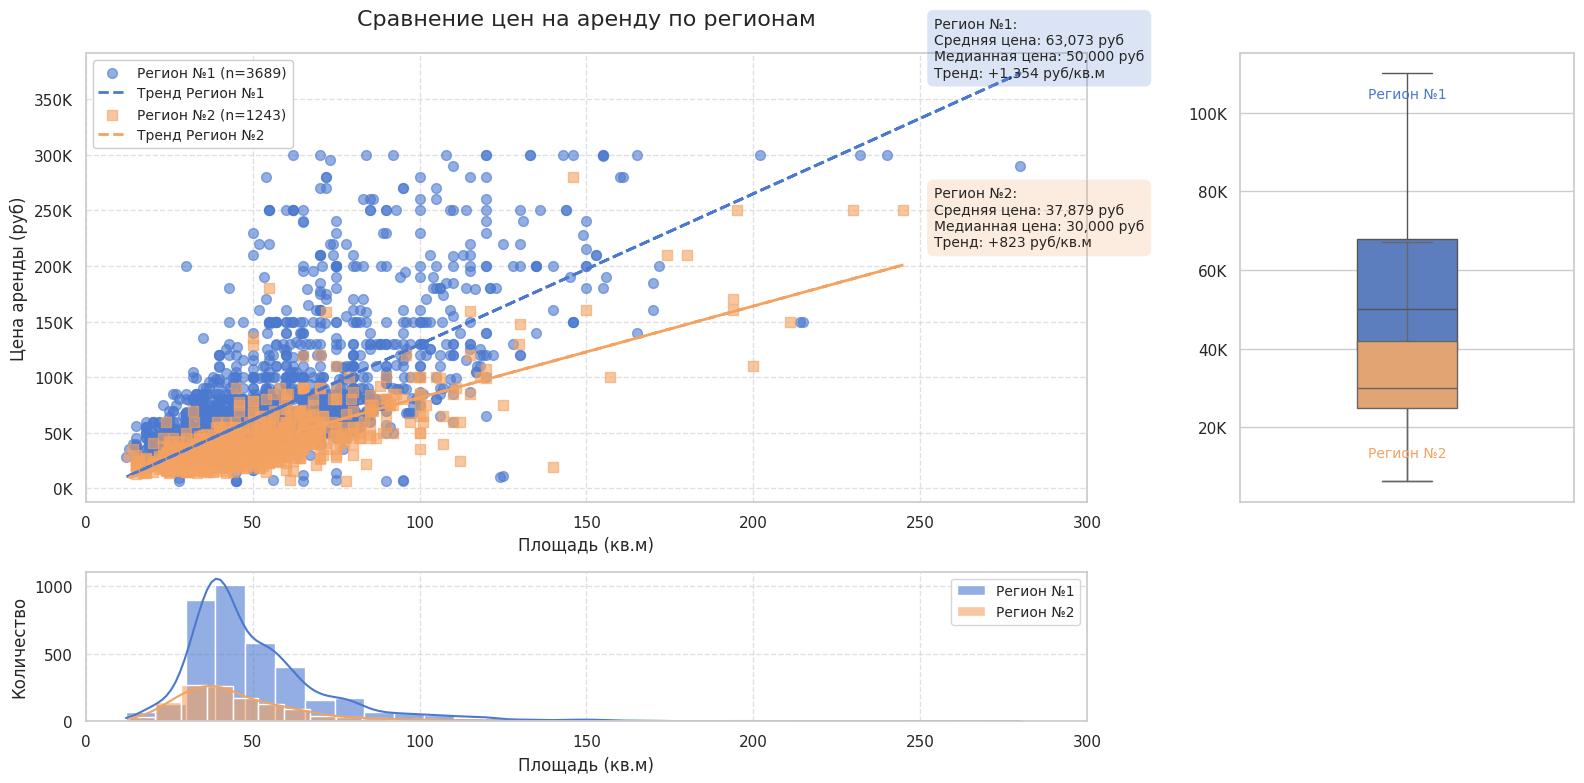


Детальное сравнение регионов:

Регион №1:
- Средняя цена: 63,073 руб
- Медианная цена: 50,000 руб
- Средняя площадь: 51.0 кв.м
- Корреляция площади и цены: 0.70

Регион №2:
- Средняя цена: 37,879 руб
- Медианная цена: 30,000 руб
- Средняя площадь: 46.9 кв.м
- Корреляция площади и цены: 0.77


In [48]:

sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

# Параметры визуализации
colors = {1: '#4B79CF', 2: '#F4A261'}  # Синий для региона 1, оранжевый для региона 2
markers = {1: 'o', 2: 's'}  # Кружки для региона 1, квадраты для региона 2
region_names = {1: 'Регион №1', 2: 'Регион №2'}  # Названия регионов

# Создаем subplot с дополнительной панелью для boxplot
grid = plt.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1])

# Основной scatter plot
ax_main = plt.subplot(grid[0, 0])
ax_box = plt.subplot(grid[0, 1])
ax_hist = plt.subplot(grid[1, 0])

# Собираем статистику для аннотаций
stats = {}

for region in [1, 2]:
    subset = df[df['region'] == region]

    # Scatter plot с разными маркерами и цветами
    ax_main.scatter(subset['area_total'],
                   subset['rent_price'],
                   alpha=0.6,
                   color=colors[region],
                   marker=markers[region],
                   label=f'{region_names[region]} (n={len(subset)})',
                   s=50)

    # Линия тренда
    subset_filtered = subset[subset['area_total'] <= 300]
    if len(subset_filtered) > 1:
        z = np.polyfit(subset_filtered['area_total'], subset_filtered['rent_price'], 1)
        p = np.poly1d(z)
        ax_main.plot(subset_filtered['area_total'],
                    p(subset_filtered['area_total']),
                    color=colors[region],
                    linewidth=2,
                    linestyle='--',
                    label=f'Тренд {region_names[region]}')

        # Сохраняем статистику
        stats[region] = {
            'slope': z[0],
            'intercept': z[1],
            'avg_price': subset['rent_price'].mean(),
            'median_price': subset['rent_price'].median()
        }

    # Boxplot для каждого региона
    sns.boxplot(y=subset['rent_price'],
                ax=ax_box,
                color=colors[region],
                width=0.3,
                showfliers=False)
    ax_box.set(ylabel='', yticklabels=[])

# Настройки основного графика
ax_main.set_xlabel('Площадь (кв.м)', fontsize=12)
ax_main.set_ylabel('Цена аренды (руб)', fontsize=12)
ax_main.set_title('Сравнение цен на аренду по регионам', fontsize=16, pad=20)
ax_main.legend(fontsize=10, framealpha=1)
ax_main.grid(True, linestyle='--', alpha=0.6)
ax_main.set_xlim(0, 300)

# Форматирование цен на оси Y
ax_main.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:,.0f}K'))
ax_box.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:,.0f}K'))

# Гистограмма распределения площадей
for region in [1, 2]:
    subset = df[df['region'] == region]
    sns.histplot(subset['area_total'],
                 ax=ax_hist,
                 color=colors[region],
                 alpha=0.6,
                 bins=30,
                 kde=True,
                 label=region_names[region])

ax_hist.set_xlabel('Площадь (кв.м)', fontsize=12)
ax_hist.set_ylabel('Количество', fontsize=12)
ax_hist.legend(fontsize=10)
ax_hist.set_xlim(0, 300)
ax_hist.grid(True, linestyle='--', alpha=0.6)

# Добавляем информативные аннотации
for region in [1, 2]:
    if region in stats:
        text = (f"{region_names[region]}:\n"
                f"Средняя цена: {stats[region]['avg_price']:,.0f} руб\n"
                f"Медианная цена: {stats[region]['median_price']:,.0f} руб\n"
                f"Тренд: +{stats[region]['slope']:,.0f} руб/кв.м")

        ax_main.annotate(text,
                         xy=(250, stats[region]['intercept'] + 250*stats[region]['slope']),
                         xytext=(10, 30) if region == 1 else (10, 10),
                         textcoords='offset points',
                         bbox=dict(boxstyle='round,pad=0.5', fc=colors[region], alpha=0.2),
                         fontsize=10)

# Размещаем подписи регионов на boxplot
for i, region in enumerate([1, 2]):
    ax_box.text(0.5 if i == 0 else 0.5,
                0.9 if i == 0 else 0.1,
                region_names[region],
                transform=ax_box.transAxes,
                ha='center',
                color=colors[region],
                fontsize=10)

plt.tight_layout()
plt.show()

# Дополнительная статистика
print("\nДетальное сравнение регионов:")
for region in [1, 2]:
    subset = df[df['region'] == region]
    print(f"\n{region_names[region]}:")
    print(f"- Средняя цена: {subset['rent_price'].mean():,.0f} руб")
    print(f"- Медианная цена: {subset['rent_price'].median():,.0f} руб")
    print(f"- Средняя площадь: {subset['area_total'].mean():.1f} кв.м")
    print(f"- Корреляция площади и цены: {subset[['area_total', 'rent_price']].corr().iloc[0,1]:.2f}")

   **Выводы по графикам**
- *Разница в количестве предложений*

  В регионе №1 на 2446 больше обьявлений чем в регионе №2.

- *Сравнение цен в регионах*

   Средняя и медианная цена в Регионе №1 выше на 66%, чем в Регионе №2.
        

 - *Зависимость цены от площади (тренд)*

      - Регион №1: +1,354 руб за каждый дополнительный кв.м

      - Регион №2: +823 руб за каждый дополнительный кв.м
    
  В Регионе №1 цена сильнее растет с увеличением площади.

 - *Гистограмма площадей*

   - Распределение площадей в обоих регионах похоже (пики в одном диапазоне);
   - Регион №1 имеет больше предложений с очень большими площадями
     (правый хвост гистограммы).

    **Итоговые выводы:**

 Регион №1 — более дорогой:

     - Выше средние цены из-за элитных предложений.

     - Сильная зависимость цены от площади.

     - Большой разброс цен (от бюджетных до премиальных).

  Регион №2 — более стабильный:

     - Меньше вариативность цен.

     - Медиана совпадает с Регионом №1, но нет дорогих выбросов.


**4. Поиск и анализ аномальных цен за аренду квартиры**

In [49]:
# Создаем две выборки по регионам
region_1 = df[df['region']==1]
region_2 = df[df['region']==2]


***Анализ в регионе №1***

In [50]:
# 1.Маленькие квартиры (до 40 кв.м) с очень высокой ценой за аренду
small_1=region_1[(region_1['area_total'] < 40) & (region_1['rent_price'] > 97500)]
display(small_1)



,id,create_date,rent_price,deposit,floor,area_total,rooms,region,agent_fee,date_only,repair_type_original,renovation_cosmetic,renovation_design,renovation_euro,renovation_no,renovation_unknown
1205,1206,2021-12-04 22:04:54.769000+03:00,98000,98000.0,2,39.0,0,1,0.0,2021-12-04,euro,0,0,1,0,0
1436,1437,2021-12-04 18:38:15.099000+03:00,100000,100000.0,12,32.0,0,1,50.0,2021-12-04,unknown,0,0,0,0,1
1441,1442,2021-12-04 18:29:28.676000+03:00,100000,100000.0,14,38.0,1,1,0.0,2021-12-04,euro,0,0,1,0,0
1442,1443,2021-12-04 18:28:41.875000+03:00,99000,0.0,2,33.0,0,1,50.0,2021-12-04,unknown,0,0,0,0,1
2129,2130,2021-12-03 23:35:51.409000+03:00,135000,135000.0,4,35.0,1,1,0.0,2021-12-03,euro,0,0,1,0,0
4132,4133,2021-12-02 14:48:01.236000+03:00,105000,105000.0,2,32.0,1,1,50.0,2021-12-02,design,0,1,0,0,0
4772,4773,2021-12-02 00:45:26.425000+03:00,200000,200000.0,23,30.0,1,1,0.0,2021-12-02,design,0,1,0,0,0


In [51]:
# 2.Большие квартиры (от 90 кв.м) с очень низкой ценой за аренду
big_1=region_1[(region_1['area_total'] > 90) & (region_1['rent_price'] < 50000)]
display(big_1)


,id,create_date,rent_price,deposit,floor,area_total,rooms,region,agent_fee,date_only,repair_type_original,renovation_cosmetic,renovation_design,renovation_euro,renovation_no,renovation_unknown
3055,3056,2021-12-03 13:20:26.061000+03:00,6300,6300.0,8,95.0,3,1,0.0,2021-12-03,unknown,0,0,0,0,1
3628,3629,2021-12-02 19:29:31.962000+03:00,11000,0.0,7,125.0,3,1,0.0,2021-12-02,unknown,0,0,0,0,1
4035,4036,2021-12-02 16:09:55.213000+03:00,8000,3000.0,3,95.0,4,1,0.0,2021-12-02,design,0,1,0,0,0
4419,4420,2021-12-02 12:55:55.948000+03:00,10000,30000.0,11,124.0,3,1,0.0,2021-12-02,design,0,1,0,0,0


**Вывод по  аномальным ценам в 1 регионе**

- Дизайнерские квартиры площадью 30 кв.м. за 200000р/мес,
 Как варинат нормы для элитного жилья в топовых локациях.

- Квартитры с большой площадью за очень маленькую цену,похоже на выбросы.
 Недостаточно данных для анализа этих значений.

 Удаляем эти строки чтобы не искажать результат работы модели.

***Анализ в регионе №2***

In [52]:
# 1.Маленькие квартиры (до 60 кв.) с высокой ценой за аренду
small_2=region_2[(region_2['area_total'] < 60) & (region_2['rent_price'] > 97500)]
display(small_2)

,id,create_date,rent_price,deposit,floor,area_total,rooms,region,agent_fee,date_only,repair_type_original,renovation_cosmetic,renovation_design,renovation_euro,renovation_no,renovation_unknown
1913,1914,2021-12-04 10:34:53.266000+03:00,128500,0.0,4,50.0,2,2,0.0,2021-12-04,euro,0,0,1,0,0
2706,2707,2021-12-03 15:42:44.545000+03:00,180000,180000.0,3,55.0,2,2,50.0,2021-12-03,unknown,0,0,0,0,1
4871,4872,2021-12-01 22:39:35.845000+03:00,135000,150000.0,3,50.0,2,2,50.0,2021-12-01,design,0,1,0,0,0


In [53]:
# 2.Большие квартиры (от 90 кв.м) с очень низкой ценой за аренду
big_2=region_2[(region_2['area_total'] > 90) & (region_2['rent_price'] < 50000)]
display(big_2)

,id,create_date,rent_price,deposit,floor,area_total,rooms,region,agent_fee,date_only,repair_type_original,renovation_cosmetic,renovation_design,renovation_euro,renovation_no,renovation_unknown
2193,2194,2021-12-03 22:03:37.484000+03:00,18900,10000.0,4,140.0,4,2,0.0,2021-12-03,design,0,1,0,0,0
3302,3303,2021-12-03 02:55:28.652000+03:00,25000,25000.0,5,112.0,4,2,50.0,2021-12-03,cosmetic,1,0,0,0,0
3804,3805,2021-12-02 18:18:45.391000+03:00,40000,0.0,3,107.0,3,2,0.0,2021-12-02,cosmetic,1,0,0,0,0
4316,4317,2021-12-02 13:54:11.810000+03:00,35000,17500.0,1,100.0,3,2,50.0,2021-12-02,design,0,1,0,0,0


**Вывод по аномальным ценам в 2 регионе**

- Квартиры площадью 50-55 кв.м. за 180000/мес, Как варинат нормы для элитного жилья в топовых локациях.

- Квартитры с большой площадью за очень маленькую цену,похоже на выбросы.Недостаточно данных для анализа этих значений.

 Удаляем эти строки чтобы не искажать результат работы модели.

In [54]:
# Удаляем строки по индексам big_1 и big_2
region_1_cleaned = region_1.drop(big_1.index)
region_2_cleaned = region_2.drop(big_2.index)

In [55]:
# Объединяем данные в единый df
combined_df = pd.concat([region_1_cleaned, region_2_cleaned], ignore_index=True)
combined_df = combined_df.reset_index(drop=True)

In [56]:
# Удалили 8 записей,тк это меньше 1% изначальных данных ,что допустимо для решения этой задачи
print(f"Удалено записей: {len(big_1) + len(big_2)}")
print(f"Итоговый датафрейм: {len(combined_df)} записей")

Удалено записей: 8
Итоговый датафрейм: 4924 записей


## **Создание новых признаков для улучшения качества модели**

**1. 'price_for_m2'**

Цена за 1 кв.м. помещения



In [57]:
# Создадим новую перемнную 'price_for_m2'- цена за м2 помещения
combined_df['price_for_m2']=np.round(combined_df['rent_price']/combined_df['area_total'],2)

**2. 'is_luxury_by_region'**

Создаем бинарную переменную, для категорирования квартир в люксовом сегменте в разбивке по регионам

In [58]:
# Сгруппируем данные по регионам и найдем медианную цену за кв.м. по каждому
median_prices = combined_df.groupby('region')['price_for_m2'].median().to_dict()

In [59]:
# Создаем переменную для определения квартир, которые по стоимости выше мединанной цены за кв.м.в каждом регионе
combined_df['is_luxury_by_region'] = combined_df.apply(
    lambda row: 1 if row['price_for_m2'] > median_prices[row['region']] else 0,
    axis=1)

**3. 'month_deposit'**

За сколько месяцев аренды берется депозит

In [60]:
combined_df['month_deposit'] = combined_df['deposit'] / combined_df['rent_price']


**4. 'deposit_group'**

 Делит депозит на 3 равные группы(тертили):
   - 1-я группа: 0–33% значений (низкий депозит);

   - 2-я группа: 33–66% (средний депозит);

   -  3-я группа: 66–100% (высокий депозит).

In [61]:
# Создаем переменную c разделением депозита на 3 группы
combined_df['deposit_group'] = pd.qcut(
    combined_df['deposit'],
    q=3,
    labels=[0, 1, 2])

In [62]:
# Переводим переменную в числовой формат
combined_df['deposit_group']=combined_df['deposit_group'].astype(int)

**5. 'is_high_floor'**

Бинарный признак  для квартир располагающихся на высоких этажах

In [63]:
# Создаем переменую для определения квартир находящихся выше 30 этажа
combined_df['is_high_floor'] = (combined_df['floor'] >= 30).astype(int)

**6. 'renovation_score'**

Признак с объединенными типами ремонта

In [64]:
# Объединяем похожие типы ремонта
combined_df['renovation_score'] = combined_df['renovation_design'] * 0.6 + combined_df['renovation_euro'] * 0.4

**7. 'is_small'**

Бинарный признак для квартир < 50 кв.м.


In [65]:
combined_df['is_small'] = (combined_df['area_total'] <= 50).astype(int)

**8. 'is_large'**

Бинарный признак для квартир > 100 кв.м.

In [66]:
combined_df['is_large'] = (combined_df['area_total'] > 100).astype(int)

**9. 'is_studio'**

Бинарный признак для квартир студий с 0-1 комнат

In [67]:
combined_df['is_studio'] = (combined_df['rooms'] <=1).astype(int)

**10. 'is_family'**

Бинарный признак для квартир с количеством комнат  > 2

In [68]:
combined_df['is_family'] = (combined_df['rooms'] > 2).astype(int)

**11. 'area_expensive'**

Показывает взаиомодействие площади квартиры с  дорогим регионом (1 регион)

In [69]:
# Создаём бинарный признак который указывает, относится ли объявление к "дорогому" региону(1 регион)
combined_df['is_expensive_region'] = (combined_df['region'] == 1).astype(int)

In [70]:
# Создаём переменную площади с дорогим регионом
combined_df['area_expensive'] = combined_df['area_total'] * combined_df['is_expensive_region']

**12. 'rooms_x_floor'**

Это произведение количества комнат (rooms) и этажа квартиры (floor).

Признак может помочь модели учитывать неочевидные зависимости между количеством комнат и этажом.

Столбцы rooms(0-5) и floor(0-55) находятся в разных масштабах.
Поэтому лучше произвести нормализацию этих столбцов.

In [71]:
#Создаем столбцы с нормализованными данными
scaler = MinMaxScaler()
combined_df[['rooms_scaled', 'floor_scaled']] = scaler.fit_transform(combined_df[['rooms', 'floor']])

In [72]:
# Создаем новый признак для обучения модели
combined_df['rooms_x_floor'] = combined_df['rooms_scaled'] * combined_df['floor_scaled']

**Создаем копию df**

In [73]:
# Создадим копию df для дальнейшей работы
df_copy = combined_df.copy(deep=True)

**Выгружаем файл для создания дашборда**

In [ ]:
from google.colab import files

# Сохраняем во временную папку Colab
df_copy.to_csv('output_data_1.csv', index=False, encoding='utf-8-sig')

# Скачиваем
files.download('output_data_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Логарифмируем  целевую переменную 'rent_price'**

In [74]:
# Логарифмируем целевую переменную для уменьшения влияния экстримальных значений
df_copy['log_rent'] = np.log1p(df_copy['rent_price'])

# **Матрица корреляций**

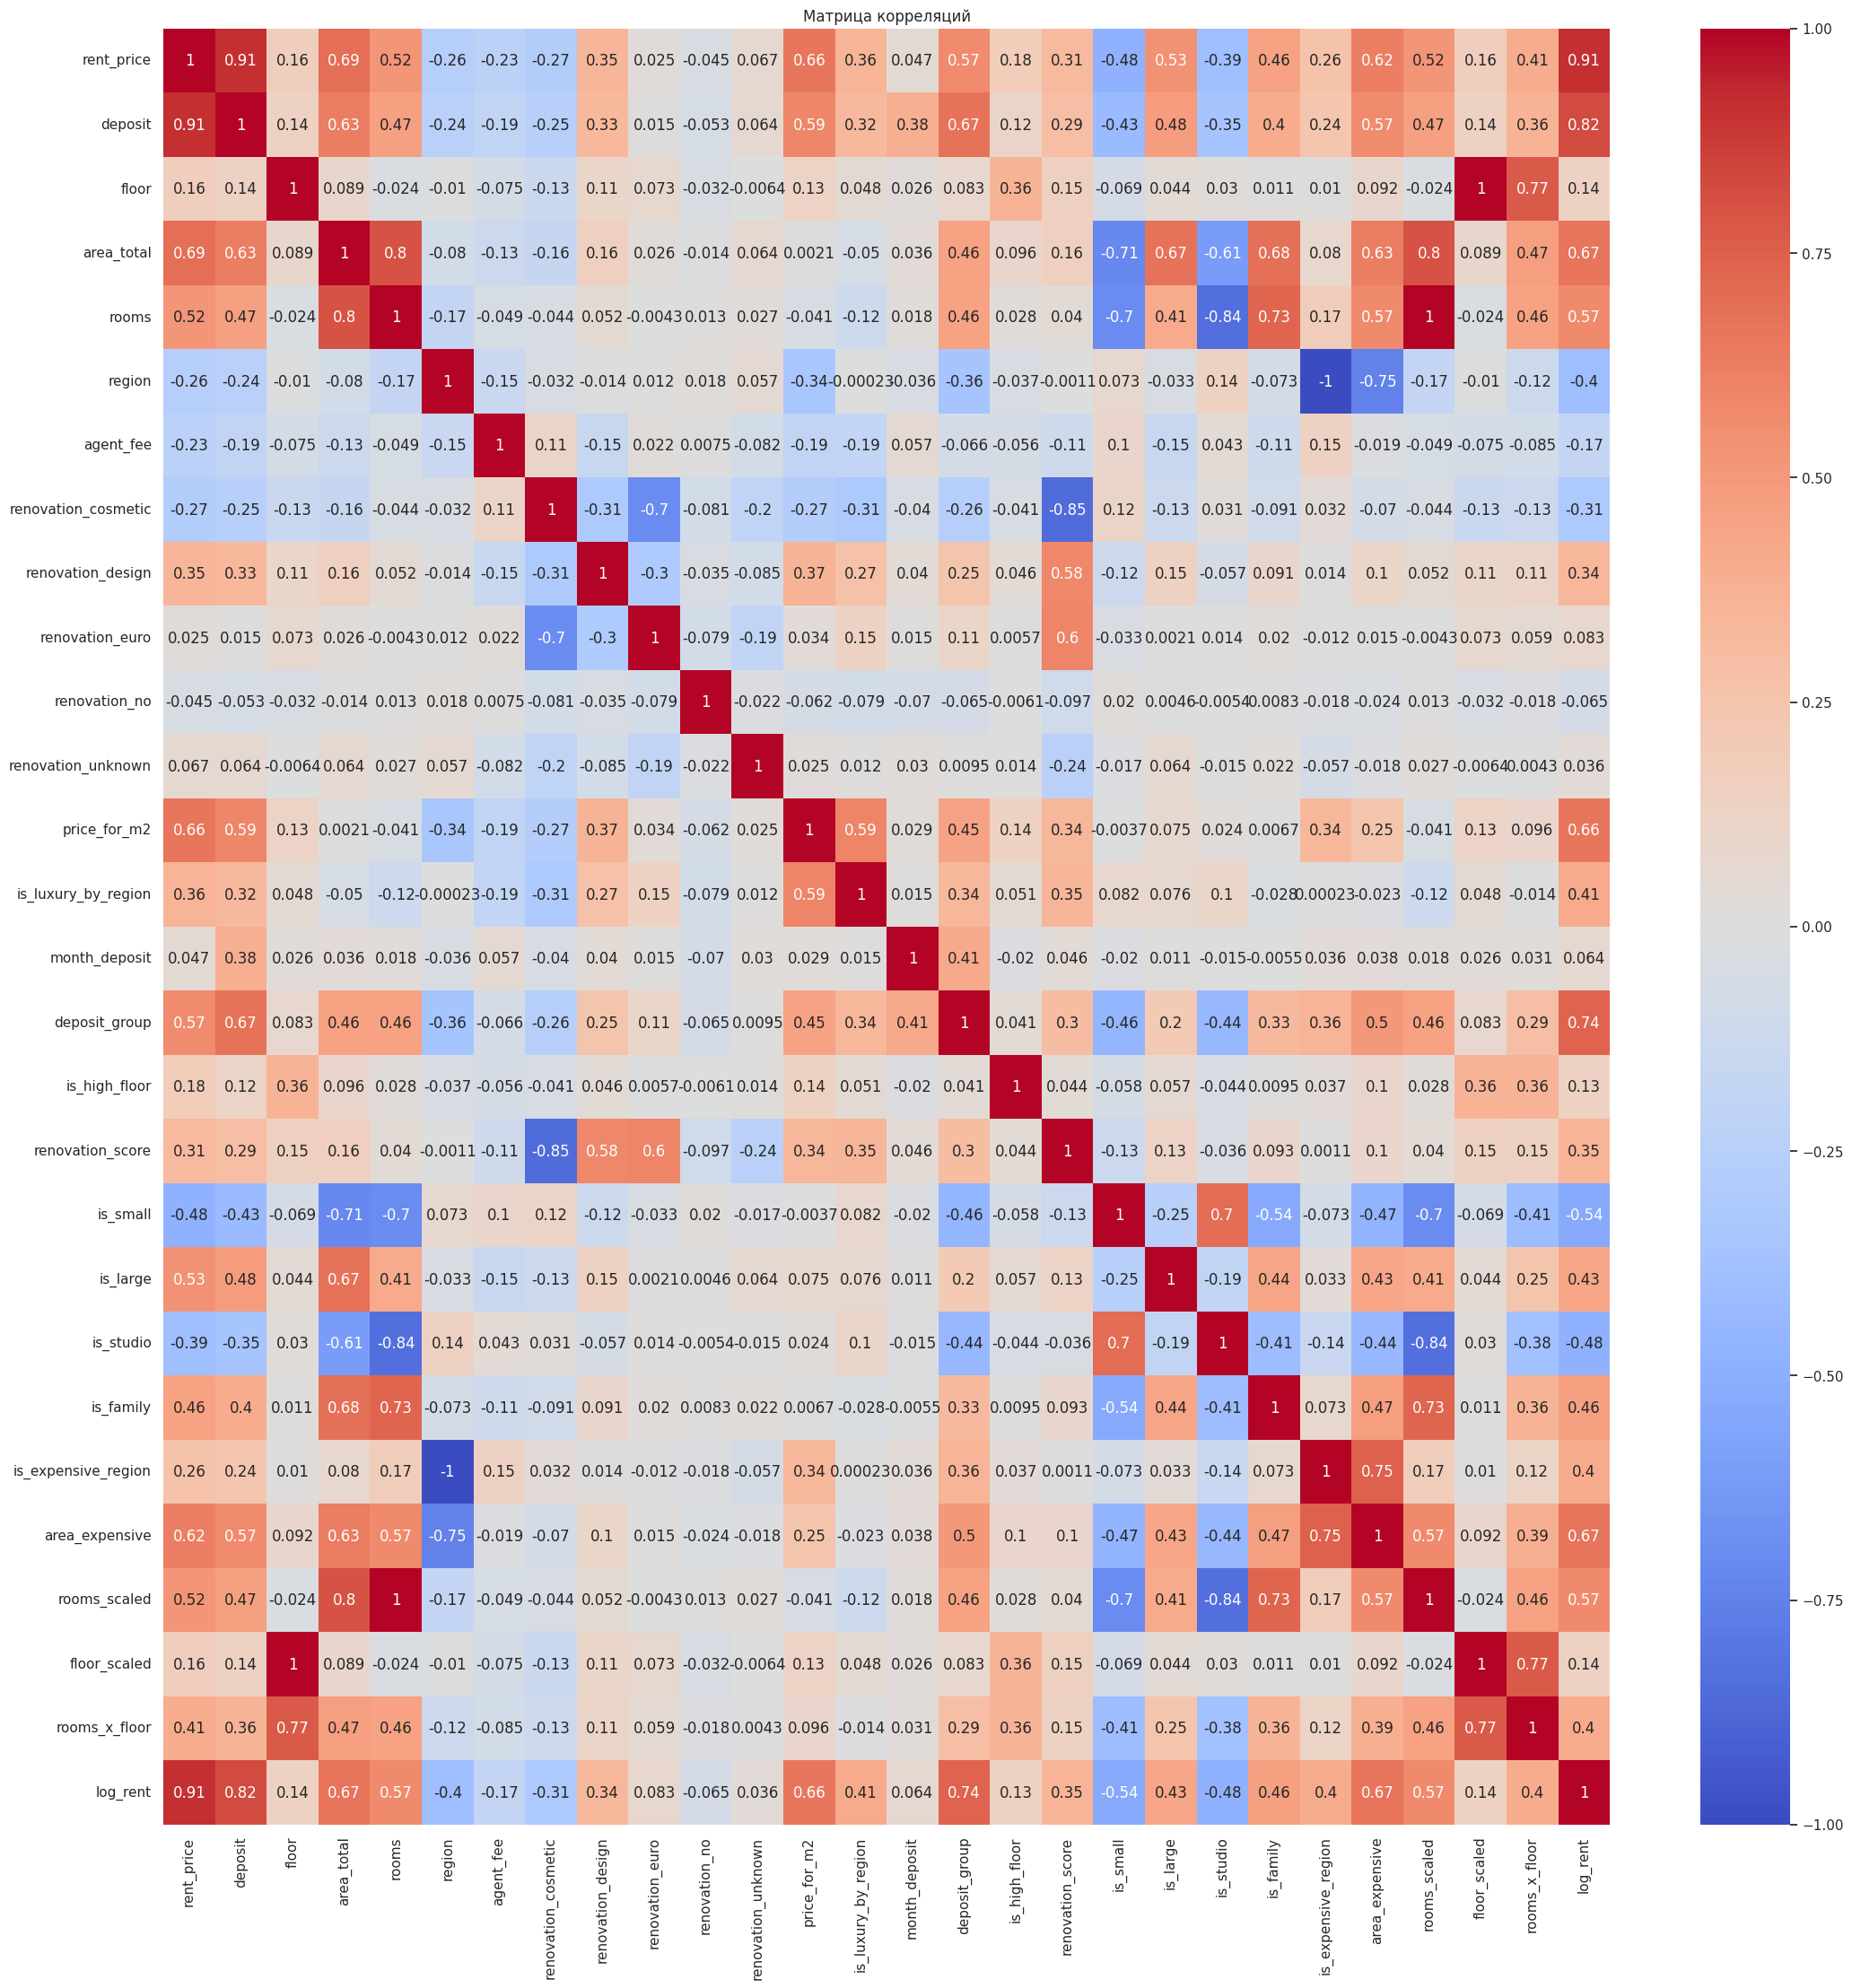

In [75]:
plt.figure(figsize=(26, 26))
corr_matrix = df_copy.drop(columns=['id']).corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Матрица корреляций")
plt.show()

**Выводы по матрице кореляций**


   ***1.Сильные корреляции (|r| > 0.7)***

- Эти признаки сильно связаны с целевой переменной (rent_price),
 что может указывать на мультиколлинеарность:

   - deposit (0.91) — очень сильная связь,он пропорционален цене аренды.

   - price_for_m2(0.66)-цена за 1 кв.м. напрямую связана с ценой за квартиру.

 - area_total (0.69)-чем больше площадь тем выше цена.

  -  rooms (0.52) — чем больше комнат, тем выше цена.
  - area_expensive- в дорогих регионах каждый м² даёт больший прирост цены,
  
   чем в обычных.


***2.Умеренные корреляции (0.3 < |r| < 0.7)***

Полезные для модели, но не вызывающие коллинеарность:

- Положительные:
  - is_family(0.46) - семейные квартиры с 2 и более комнат дороже стоят
  - is_large(0.53) - квартиры более 100 кв.м. дороже в цене

  - renovation_design (0.35) - дизайнерский ремонт повышает цену.

  - is_luxury_by_region (0.36) — премиальный регион повышают цену.

- Отрицательные:

 - is_small (-0.48) — малогабаритные квартиры дешевле
 - is_studio (-0.39) — квартиры студии в большинстве случаев дешевле
 - region (-0.26) — в некоторых регионах цены ниже.

***3. Слабые корреляции (|r| < 0.3)***

- Малоинформативные для прогнозирования цены:
 - floor (0.16) — этаж почти не влияет на цену.
 - renovation_no (-0.045), renovation_unknown (0.067) — тип ремонта незначим.
  - month_deposit (0.047) — ежемесячный депозит слабо связан с ценой.

# **Создание ML моделей**

# **Модель №1**
# RandomForestRegressor

**Создание и обучение**

Для  X взяли логарифмированную целевую переменную (rent_price).

Исходная rent_price имеет ассиметричное распределение скошенное вправо,

поэтому log(price) будет ближе к нормальному распределению.

In [76]:
# Опрелелили зависимые и независимые переменные
X=df_copy[['is_high_floor','is_small','is_studio','renovation_score','is_family','region','is_luxury_by_region','floor','rooms','renovation_cosmetic','renovation_design','renovation_euro',
'is_large','month_deposit','area_total','area_expensive','rooms_x_floor']]
Y=df_copy['log_rent']

In [77]:
# Разделяем данные на тренировочные и тестовые (70% для тренировки, 30% для теста)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [78]:
# Создаем модель RandomForestRegressor
model_1 = RandomForestRegressor(random_state=42)

In [79]:
# Обучение модели на тренировочных данных
model_1.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

**Прогнозирование**

In [80]:
# Прогнозирование на тестовых данных
Y_pred_rf = model_1.predict(X_test)

**Точность модели**

In [81]:
# Оценка точности модели (Ошибки измеряются в логарифмах)
print(f"Метрики в логарифмированной шкале:")
print('MSE: %.2f' % mean_squared_error(Y_test, Y_pred_rf))
print('MAE: %.2f' % mean_absolute_error(Y_test, Y_pred_rf))
print('R2: %.2f' % r2_score(Y_test, Y_pred_rf))

Метрики в логарифмированной шкале:
MSE: 0.05
MAE: 0.16
R2: 0.79


In [82]:
# Обратное преобразование(возвращение к рублевым показателям)
y_true_original = np.expm1(Y_test)  # обратное преобразование фактических значений
y_pred_original = np.expm1(Y_pred_rf)  # обратное преобразование предсказанных значений

In [83]:
real_mse = mean_squared_error(y_true_original, y_pred_original)
real_mae = mean_absolute_error(y_true_original, y_pred_original)
real_r2 = r2_score(y_true_original, y_pred_original)
# Добавляем маленькое число, чтобы избежать деления на ноль
real_mape = np.mean(np.abs((y_true_original - y_pred_original) / (y_true_original + 1e-10))) * 100

In [84]:
print(f"\nМетрики в исходном масштабе (рубли):")
print(f"MSE: {real_mse:,.2f}")
print(f"MAE: {real_mae:,.2f}")
print(f"R2: {real_r2:.2f}")
print(f"MAPE: {real_mape:.2f}%")


Метрики в исходном масштабе (рубли):
MSE: 429,196,926.27
MAE: 10,382.51
R2: 0.73
MAPE: 16.76%


<Axes: >

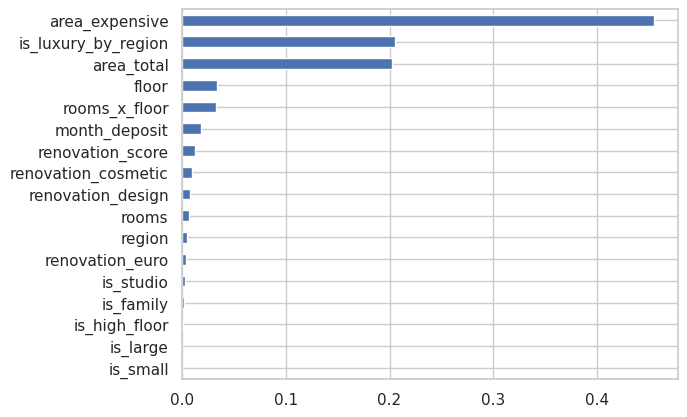

In [85]:
# Визуализация важности признаков в обученной модели
importances = model_1.feature_importances_
pd.Series(importances, index=X.columns).sort_values().plot(kind='barh')

# **Модель №2**
   # XGBRegressor

**Создание и обучение**

Для  X взяли логарифмированную целевую переменную (rent_price).

Исходная rent_price была скошена вправо (много дешёвых и мало дорогих квартир),

log(price) ближе к нормальному распределению.

In [117]:
# Используем те же переменные X и Y, что и в 1ой модели
X=df_copy[['is_high_floor','is_small','is_studio','renovation_score','is_family','region','is_luxury_by_region','floor','rooms','renovation_cosmetic','renovation_design','renovation_euro',
'is_large','month_deposit','area_total','area_expensive','rooms_x_floor']]
Y=df_copy['log_rent']

In [118]:
# Создаем модель XGBRegressor
model_2 = XGBRegressor(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [119]:
# Обучение модели на тренировочных данных
model_2.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [120]:
# Прогнозирование на тестовых данных
Y_pred_xgb = model_2.predict(X_test)

In [121]:
# Оценка точности модели (Ошибки измеряются в логарифмах)
print(f"Метрики в логарифмированной шкале:")
print('MSE: %.2f' % mean_squared_error(Y_test, Y_pred_xgb))
print('MAE: %.2f' % mean_absolute_error(Y_test, Y_pred_xgb))
print('R2: %.2f' % r2_score(Y_test, Y_pred_xgb))

Метрики в логарифмированной шкале:
MSE: 0.05
MAE: 0.15
R2: 0.82


In [122]:
# Обратное преобразование ТОЛЬКО для тестовых данных
y_true_original_xgb = np.expm1(Y_test)  # обратное преобразование фактических значений
y_pred_original_xgb = np.expm1(Y_pred_xgb)  # обратное преобразование предсказанных значений


In [123]:
real_mse_xgb = mean_squared_error(y_true_original_xgb, y_pred_original_xgb)
real_mae_xgb = mean_absolute_error(y_true_original_xgb, y_pred_original_xgb)
real_r2_xgb = r2_score(y_true_original_xgb, y_pred_original_xgb)
real_mape_xgb = np.mean(np.abs((y_true_original_xgb - y_pred_original_xgb) / (y_true_original_xgb + 1e-10))) * 100

In [124]:
print(f"\nМетрики в исходном масштабе (рубли):")
print(f"MSE: {real_mse_xgb:,.2f}")
print(f"MAE: {real_mae_xgb:,.2f}")
print(f"R2: {real_r2_xgb:.2f}")
print(f"MAPE: {real_mape_xgb:.2f}%")


Метрики в исходном масштабе (рубли):
MSE: 356,690,581.70
MAE: 9,824.64
R2: 0.77
MAPE: 15.76%


<Axes: >

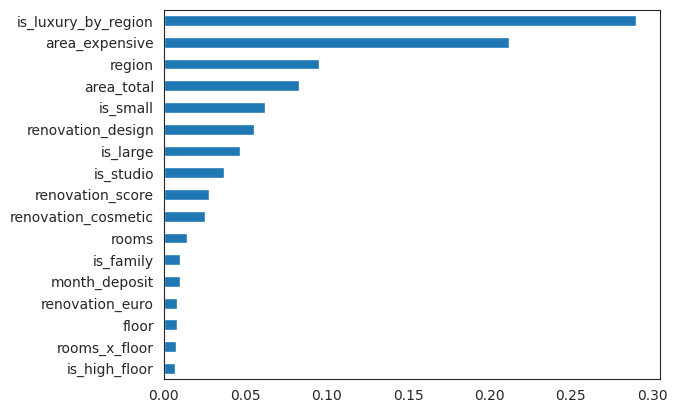

In [125]:
# Визуализация важности признаков в обученной модели
importances = model_2.feature_importances_
pd.Series(importances, index=X.columns).sort_values().plot(kind='barh')

# **Визуализация результатов работы двух моделей**

Сравнение их предсказаний с истиным значениями (Y),

 после преобразования в исходный масштаб (рублевый)

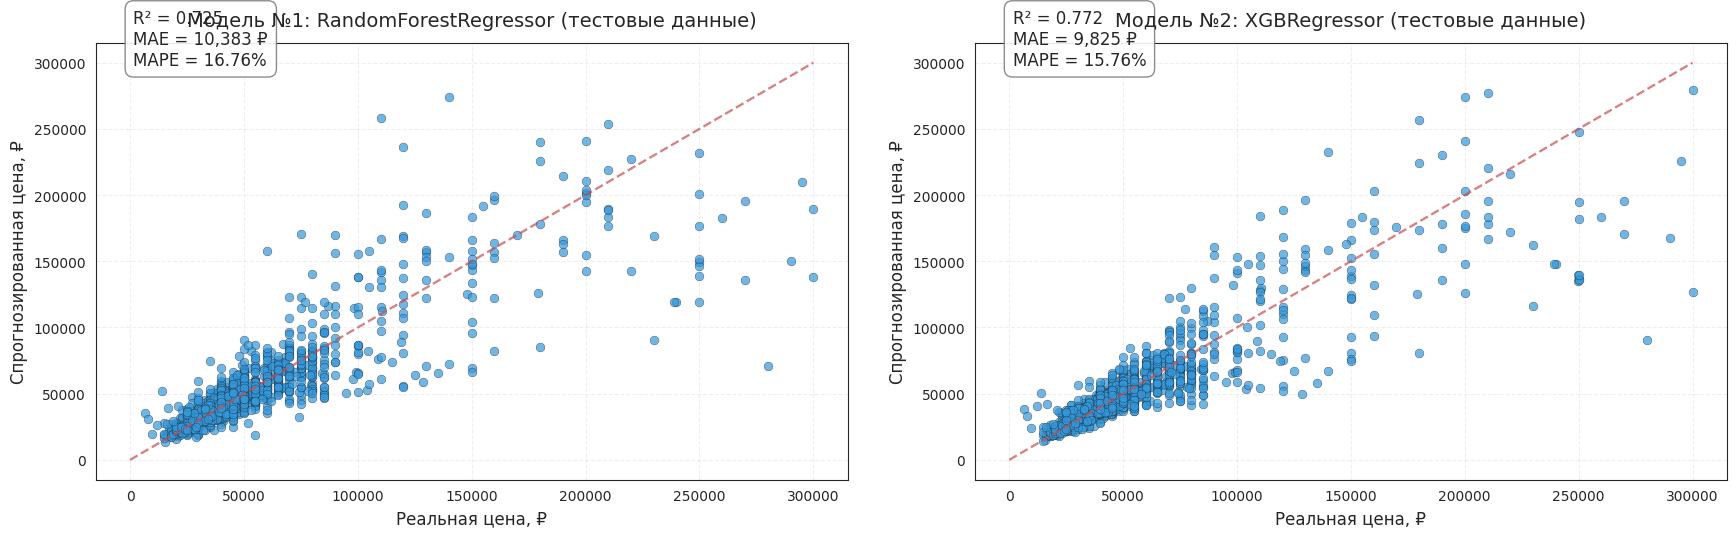


СРАВНЕНИЕ МОДЕЛЕЙ (на тестовых данных):
Random Forest: R² = 0.725, MAE = 10,383 ₽, MAPE = 16.76%
XGBoost:       R² = 0.772, MAE = 9,825 ₽, MAPE = 15.76%


In [126]:
# Настройка стиля - белый фон
plt.style.use('default')
sns.set_style("white")

# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')

# --- График для Model 1 (Random Forest) ---
# Обратное преобразование для тестовых данных
y_true_rf = np.expm1(Y_test)  # фактические значения из теста
y_pred_rf = np.expm1(Y_pred_rf)  # предсказанные значения для теста

# Точки-реальные данные
sns.scatterplot(x=y_true_rf, y=y_pred_rf, ax=ax1,
                alpha=0.7, s=40, color='#3498db',
                edgecolor='k', linewidth=0.3)

# Линия идеального предсказания (y = x)
max_val_rf = max(max(y_true_rf), max(y_pred_rf))
ax1.plot([0, max_val_rf], [0, max_val_rf], 'r--', linewidth=1.7, alpha=0.7)

# Вычисляем метрики на тестовых данных
r2_1 = r2_score(y_true_rf, y_pred_rf)
mae_1 = mean_absolute_error(y_true_rf, y_pred_rf)
mape_1 = np.mean(np.abs((y_true_rf - y_pred_rf) / (y_true_rf + 1e-10))) * 100

# Красивое отображение метрик
ax1.text(0.05, 0.95,
        f"R² = {r2_1:.3f}\nMAE = {mae_1:,.0f} ₽\nMAPE = {mape_1:.2f}%",
        transform=ax1.transAxes,
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.9,
                 edgecolor='gray', boxstyle='round,pad=0.5'))

ax1.set_title("Модель №1: RandomForestRegressor (тестовые данные)", fontsize=14, pad=12)
ax1.set_xlabel("Реальная цена, ₽", fontsize=12)
ax1.set_ylabel("Спрогнозированная цена, ₽", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3)

# --- График для Model 2 (XGBoost) ---
# Обратное преобразование для тестовых данных
y_true_xgb = np.expm1(Y_test)  # фактические значения из теста (те же самые)
y_pred_xgb = np.expm1(Y_pred_xgb)  # предсказанные значения XGBoost для теста

# Точки-реальные данные
sns.scatterplot(x=y_true_xgb, y=y_pred_xgb, ax=ax2,
                alpha=0.7, s=40, color='#3498db',
                edgecolor='k', linewidth=0.3)

# Линия идеального предсказания (y = x)
max_val_xgb = max(max(y_true_xgb), max(y_pred_xgb))
ax2.plot([0, max_val_xgb], [0, max_val_xgb], 'r--', linewidth=1.7, alpha=0.7)

# Вычисляем метрики на тестовых данных
r2_2 = r2_score(y_true_xgb, y_pred_xgb)
mae_2 = mean_absolute_error(y_true_xgb, y_pred_xgb)
mape_2 = np.mean(np.abs((y_true_xgb - y_pred_xgb) / (y_true_xgb + 1e-10))) * 100

# Отображение метрик
ax2.text(0.05, 0.95,
        f"R² = {r2_2:.3f}\nMAE = {mae_2:,.0f} ₽\nMAPE = {mape_2:.2f}%",
        transform=ax2.transAxes,
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.9,
                 edgecolor='gray', boxstyle='round,pad=0.5'))

ax2.set_title('Модель №2: XGBRegressor (тестовые данные)', fontsize=14, pad=12)
ax2.set_xlabel("Реальная цена, ₽", fontsize=12)
ax2.set_ylabel("Спрогнозированная цена, ₽", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

# Общие настройки
plt.tight_layout(pad=3)
plt.show()

# Вывод сравнения
print("\n" + "="*50)
print("СРАВНЕНИЕ МОДЕЛЕЙ (на тестовых данных):")
print("="*50)
print(f"Random Forest: R² = {r2_1:.3f}, MAE = {mae_1:,.0f} ₽, MAPE = {mape_1:.2f}%")
print(f"XGBoost:       R² = {r2_2:.3f}, MAE = {mae_2:,.0f} ₽, MAPE = {mape_2:.2f}%")
print("="*50)

## Выводы

На основе представленных результатов можно сделать следующие ключевые выводы:

### 1. Сравнение эффективности моделей

| Модель | R² | MAE (₽) | MAPE | Визуальная оценка |
|--------|-----|---------|------|-------------------|
| RandomForestRegressor | 0.73 | 10,383 | 16.76% | Больше выбросов, шире разброс |
| XGBRegressor | **0.78** | **9,825** | **15.76%** | Плотнее у диагонали, меньше выбросов |

**XGBoost показывает лучшие результаты по всем метрикам:**
- Выше объясняющая способность (R² 0.78 против 0.73)
- Ниже абсолютная ошибка (на 632 ₽ в среднем)
- Ниже процентная ошибка (на 1.1 п.п.)

### 2. Анализ графиков предсказаний

**2.1. Общие закономерности для обеих моделей:**
- Хорошо работают в диапазоне до 100,000 ₽ (основной сегмент)
- Среднее качество в диапазоне 100,000-150,000 ₽
- Недооценивают дорогие объекты (>150,000 ₽) - точки ниже линии

**2.2. Отличия:**
- **Random Forest:** больше точек, значительно отклоняющихся от линии, особенно в верхнем сегменте
- **XGBoost:** более компактное облако точек, лучшее поведение на границах диапазона

### 3. Интерпретация метрик

**MAPE = 15.76% означает:**
- В среднем модель ошибается на ~15-16% от реальной цены
- Для квартиры за 50,000 ₽: ошибка ~7,500-8,000 ₽
- Для квартиры за 100,000 ₽: ошибка ~15,000-16,000 ₽

Это хороший показатель для рынка недвижимости, где цены могут варьироваться в широких пределах и зависеть от множества субъективных факторов.

### 4. Сильные стороны моделей

- Успешно улавливают основные закономерности рынка
- Хорошо работают на массовом сегменте
- Стабильные результаты (разница между моделями небольшая)
- Процентная ошибка в приемлемых пределах

### 5. Ограничения и зоны роста

**Премиальный сегмент (>200,000 ₽) требует отдельного подхода:**
- Мало данных для обучения
- Уникальные характеристики объектов плохо учитываются
- Высокая волатильность цен
- Систематическая недооценка самых дорогих объектов

## Рекомендации

### Как использовать
- **Для квартир до 100,000 ₽** - можно полностью автоматизировать оценку
- **Для квартир 100,000-150,000 ₽** - использовать как рекомендацию с проверкой
- **Для квартир >150,000 ₽** - только как вспомогательный инструмент, обязательна экспертная оценка

### Для внедрения
- Выбрать **XGBoost** как основную модель - лучший баланс точности и стабильности
- Для предсказаний до 200,000 ₽ можно доверять модели с высокой уверенностью
- Для премиальных объектов добавить экспертную проверку или отдельную модель

### Для улучшения
- Собрать больше данных по премиальному сегменту
- Добавить признаки, важные для дорогих объектов (локация, исторический центр, инфраструктура)
- Рассмотреть отдельную модель для квартир >200,000 ₽
- Добавить бизнес-правила для корректировки выбросов

## Заключение

Разработанная модель **XGBoost с MAPE 15.76% и R² 0.78** готова к практическому использованию для прогнозирования цен аренды квартир в массовом сегменте. Модель успешно решает поставленную задачу и может быть рекомендована для внедрения в бизнес-процессы оценки недвижимости.